In [2]:
import os
import json


DATASET_DIR = '../01_data'

# Build connectivity matrix

In [45]:
with open(os.path.join(DATASET_DIR, 'neuron_ids.json')) as f:
    d = json.load(f)
    
neuron_ids = d['valid_20000']
neuron_id_set = set(neuron_ids)

print(f'get {len(neuron_ids)} valid neurons.')

# with open(os.path.join(DATASET_DIR, 'atlas/nblast/neuron_groups.json')) as f:
#     d = json.load(f)
    
# for group_name, group in d.items():
#     if 'anatomi' in group_name: #or 'outliers' in goup_name:
#         continue
#     neuron_ids = 

get 3075 valid neurons.


In [4]:
import pandas as pd

df = pd.read_csv(os.path.join(DATASET_DIR, 'synapse_final.df'))
print(f'number of all synapses: {len(df)}')

df = df.dropna()
print(f'number of synapses after dropping NaN: {len(df)}')

number of all synapses: 2036892
number of synapses after dropping NaN: 1995282


In [5]:
import numpy as np
presyn_seg_id = df.loc[:, 'presyn_segid'].to_numpy(dtype=np.int)
selection_pre = np.isin(presyn_seg_id, np.asarray(neuron_ids) )
assert np.any(selection_pre)
print(f'selected {np.count_nonzero(selection_pre)} synapses.')

postsyn_seg_id = df.loc[:, 'postsyn_segid'].to_numpy(dtype=np.int)
selection_post = np.isin(postsyn_seg_id, np.asarray(neuron_ids) )
assert np.any(selection_post)
print(f'selected {np.count_nonzero(selection_post)} synapses')

selection_self_conn = (postsyn_seg_id != presyn_seg_id)

# remove self connection
selection = selection_pre * selection_post * selection_self_conn

print(f'selected {np.count_nonzero(selection)} synapses.')

df = df.loc[selection, ['presyn_segid', 'postsyn_segid', 'size']].astype('uint32')
df

selected 285061 synapses.
selected 288463 synapses
selected 88538 synapses.


,presyn_segid,postsyn_segid,size
1138,80227,76263,977
1144,81319,76263,1797
1185,80271,76263,672
1196,76782,76263,2276
2320,81061,76263,1441
...,...,...,...
2014804,79356,79395,704
2015158,79465,79395,1771
2015687,79373,79395,519
2015884,78090,79395,4884


In [6]:
import networkx as nx
edges = [(f,t,w) for f,t,w in zip(df['presyn_segid'], df['postsyn_segid'], df['size'])]

# it seems that although MultiDiGraph is the best model, 
# but it is not easy to do analysis using this model
# MG = nx.MultiDiGraph()
# MG.add_weighted_edges_from( edges )
# print(f'number of nodes in graph: {len(MG)}')

DiG = nx.DiGraph()
for n1, n2, size in edges:
    if DiG.has_edge(n1, n2):
        DiG.edges[n1,n2]['syn_num'] += 1
        DiG.edges[n1,n2]['syn_size'] += size
    else:
        DiG.add_edge( n1, n2, syn_size=size, syn_num=1 )

from networkx.readwrite import write_graphml

write_graphml(DiG, os.path.join(DATASET_DIR, 'syn_digraph.graphml.gz'))

# the plot is very dense and can not see anything useful
# import matplotlib.pyplot as plt
# nx.draw(G)
# plt.show()

In [7]:
orphan_neurons = neuron_id_set.difference(set(DiG.nodes))

print(f'get {len(orphan_neurons)} orphan neurons, and they will be excluded.')

neuron_ids = list(DiG.nodes)

with open(os.path.join(DATASET_DIR, 'neuron_ids.json')) as f:
    d = json.load(f)

d['connected'] = neuron_ids

with open(os.path.join(DATASET_DIR, 'neuron_ids.json'), 'w') as f:
    json.dump(d, f)
    
print(f'only use the connected {len(neuron_ids)} neurons.')

get 109 orphan neurons, and they will be excluded.
only use the connected 2966 neurons.


In [8]:
# orphan_neurons

In [9]:
# main_components = {}
# for g in nx.weakly_connected_components(G):
#     if len(g) > 2:
#         print(f'get main component with {len(g)} nodes.')
#         main_components = g

# with open(os.path.join(DATASET_DIR, 'neuron_ids.json')) as f:
#     d = json.load(f)
#     d['connected'] = list(main_components)
    
# with open(os.path.join(DATASET_DIR, 'neuron_ids.json'), 'w') as f:
#     json.dump(d, f)
    
    
    
# for k in d:
#     print(k)

In [10]:
print(f'number of nodes: {len(DiG)}')
print(f'number of edges: {len(DiG.edges())}')

number of nodes: 2966
number of edges: 53151


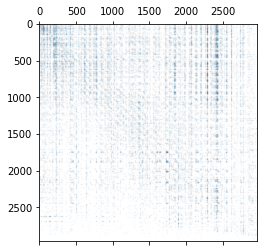

In [13]:
import matplotlib.pylab as plt

A = nx.adjacency_matrix(DiG, nodelist=neuron_ids, weight='syn_num')

# plt.spy(A, markersize=0.01)



In [79]:
postsyn_num = A.sum(axis=0).getA1()
presyn_num = A.sum(axis=1).getA1()

assert presyn_num[0] == A[0,:].sum()
assert postsyn_num[0] == A[:, 0].sum()

import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Range1d
 

output_notebook()



TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)
p.scatter(presyn_num, postsyn_num)

p.x_range = Range1d(0, presyn_num.max()+5)
p.y_range = Range1d(0, postsyn_num.max()+10)
p.xaxis.axis_label = 'presynapse number'
p.yaxis.axis_label = 'postsynpse number'

# p.output_backend = "png"
show(p)

Loading BokehJS ...

ValueError: invalid value: 'png'; allowed values are canvas, svg or webgl

# Connectivity analysis
## Motif detection 
triplets

## circle or feed forward

# Community detection of undirected graph

get 7 communities.


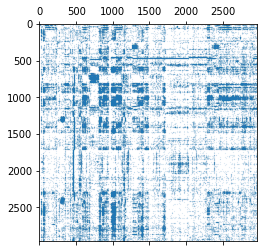

In [14]:
from networkx.algorithms import community

G = DiG.to_undirected()
write_graphml(G, os.path.join(DATASET_DIR, 'syn_graph.graphml.gz'))

# c = list(community.asyn_lpa_communities(G))
c = list( community.label_propagation_communities(G) )
# this only works with undirected graph
# c = list( community.greedy_modularity_communities(G) )

print(f'get {len(c)} communities.')

# plot the reordered graph
nid2idx = {}
for i, nid in enumerate(neuron_ids):
    nid2idx[ nid ] = i

reordered_neuron_ids = []
for nids in c:
    reordered_neuron_ids.extend(nids)

# reorder adjacency matrix
A = nx.to_scipy_sparse_matrix(G, reordered_neuron_ids, weight='syn_num')
plt.spy(A, marker='.', markeredgecolor=None, markersize=0.1)
plt.savefig(os.path.join(DATASET_DIR, 'fig/label_propagation_communites.png'), dpi=600, transparent=True)

In [15]:
c

[{76863, 78120},
 {80021, 80041},
 {82754, 82803},
 {77485, 77508},
 {76892, 76900, 79124, 79642},
 {76857, 76864},
 {82140,
  82143,
  82145,
  82146,
  82160,
  82161,
  82163,
  82165,
  82166,
  82169,
  82170,
  82171,
  82172,
  82173,
  82174,
  82175,
  82176,
  82178,
  82179,
  82180,
  82181,
  82182,
  82184,
  82185,
  82186,
  82187,
  82188,
  82189,
  82190,
  82192,
  82193,
  82194,
  82195,
  82196,
  82197,
  82212,
  82213,
  82216,
  82217,
  82218,
  82220,
  82248,
  82250,
  82263,
  82264,
  82266,
  82267,
  82268,
  82269,
  82270,
  82283,
  82290,
  82291,
  82292,
  82293,
  82294,
  82295,
  82298,
  82299,
  82305,
  82307,
  82309,
  82310,
  82312,
  82313,
  82315,
  82316,
  82318,
  82323,
  82324,
  82326,
  82328,
  82330,
  82331,
  82332,
  82333,
  82339,
  82340,
  82341,
  82348,
  82349,
  82351,
  82353,
  82355,
  82357,
  82359,
  82360,
  82363,
  82366,
  82367,
  82371,
  82372,
  82373,
  82381,
  82382,
  82385,
  82386,
  82389,
  

## community detection using graph-tool

community number:  112


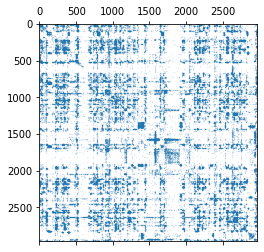

In [16]:
sbm_community_ids = np.load(os.path.join(DATASET_DIR, 'sbm_community_ids.npy')).tolist()
community_num = len(np.unique(sbm_community_ids))
print('community number: ', community_num)

comid2neuids= [[] for _ in range(community_num)]

for idx, community_id in enumerate(sbm_community_ids):
    neuron_id = neuron_ids[ idx ]
    comid2neuids[community_id].append( neuron_id )
    
reordered_neuron_ids = []
for nids in comid2neuids:
    reordered_neuron_ids.extend( nids )
# reorder adjacency matrix
A = nx.to_scipy_sparse_matrix(G, reordered_neuron_ids, weight='syn_num')
plt.spy(A, marker='.', markeredgecolor=None, markersize=0.1)
plt.savefig(os.path.join(DATASET_DIR, 'fig/sbm_communites.png'), dpi=600, transparent=True)

In [17]:
from scipy import sparse
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook

output_notebook()

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

plot = figure(tools=TOOLS)
# p.output_backend = 'svg'

X, Y, R = sparse.find(A)
plot.scatter( X,Y, radius=R, line_color=None )

def print_selected( attr, old, new ):
    print( new )

handle = show(plot, notebook_handle=True)

push_notebook(handle=handle)

# show(p)

Loading BokehJS ...

# Clustering based on connectivity profile
For each neuron in graph, the connectivity profile is a aggregation of synaptic connectivity pattern, including synpase number and size.
also the input and output.

In [18]:
A_num = nx.adjacency_matrix(DiG, nodelist=neuron_ids, weight='syn_num')
A_size = nx.adjacency_matrix(DiG, nodelist=neuron_ids, weight='syn_size')

# normalize the value
A_num = A_num.astype(np.float32)
A_num /= A_num.max()
assert A_num.max() == 1

A_size = A_size.astype(np.float32)
A_size /= A_size.max()
assert A_size.max() == 1

In [19]:
# construct connectivity profile
from scipy.sparse import hstack
N = A_num.shape[0]
# X = np.zeros((N, N*4), dtype=np.float32)
# X = hstack([A_num, A_num.transpose(), A_size, A_size.transpose()])
A = (A_num + A_size) / 2
X = hstack( [ A, A.transpose() ] )
X = X.toarray()

assert X.shape[1] == 2*N


perplexity=10 takes 1.7723975817362467 min.
perplexity=20 takes 1.749307636419932 min.


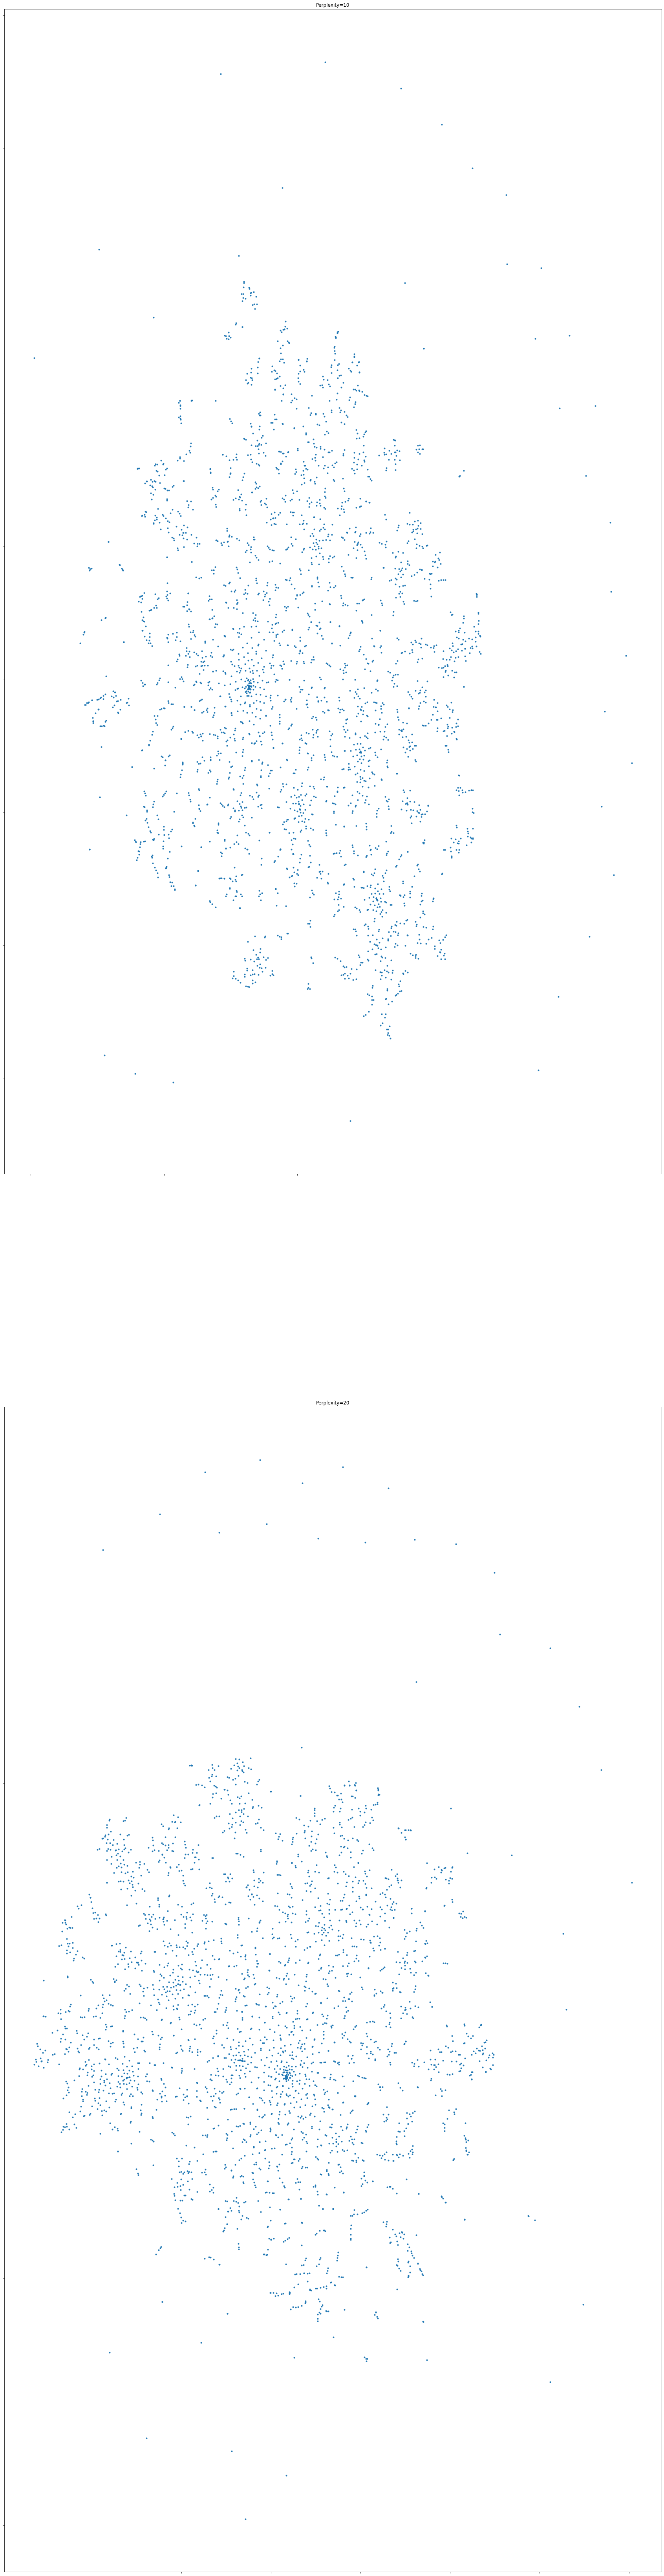

In [21]:
from sklearn import manifold
from matplotlib.ticker import NullFormatter
from time import time

# perplexities = [5, 10, 20, 30]
perplexities = [10, 20]

(fig, subplots) = plt.subplots(len(perplexities), figsize=(30, 120))

Ys = []
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    
    t0 = time()
    tsne = manifold.TSNE(init='random', random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    Ys.append(Y)
    t1 = time()
    
    print(f'perplexity={perplexity} takes {(t1-t0)/60} min.')
    
    ax.set_title(f'Perplexity={perplexity}')
    ax.scatter(Y[:,0], Y[:,1], marker='.')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    


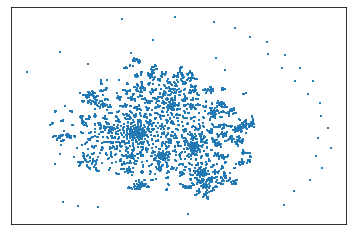

In [22]:
# (fig, subplots) = plt.subplots(1, figsize=(2, 2))
# for i, perplexity in enumerate(perplexities):
# i = 0
# ax = subplots[i]
#     ax.set_title(f'Perplexity={perplexity}')
Y = Ys[0]
plt.scatter(Y[:,0], Y[:,1], s=1, marker=',', 
            linewidths=None, edgecolors=None, facecolors='C0')
plt.axis('tight')
plt.xticks( ticks=[] )
plt.yticks( ticks=[] )
plt.savefig(os.path.join(DATASET_DIR, 'fig/tsne.png'), transparent=True, dpi=600)

number of groups:  40


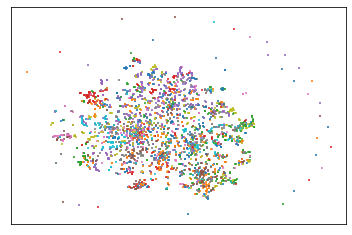

In [23]:
nid2idx = {}
for idx,nid in enumerate(neuron_ids):
    nid2idx[ nid ] = idx
    
with open(os.path.join(DATASET_DIR, 'atlas/nblast/manual_split_neuron_groups.json')) as f:
    neuron_groups = json.load(f)
    
print('number of groups: ', len(neuron_groups))

for group_id, group in enumerate( neuron_groups ):
    indices = []
    for nid in group:
        if nid in nid2idx:
            idx = nid2idx[ nid ]
            indices.append( idx )
    plt.scatter(Y[indices,0], Y[indices,1], s=1, marker=',', alpha=0.8)
    
plt.axis('tight')
plt.xticks( ticks=[] )
plt.yticks( ticks=[] )
plt.savefig(os.path.join(DATASET_DIR, 'fig/tsne.png'), transparent=True, dpi=600)

# Merge nodes according to morphological classification
We classified 2522 neurons to 36 groups by hierarchical NBLAST clustering and manual splitting.

In [24]:
# load morphological clustering result
import json

with open(os.path.join(DATASET_DIR, 
                  'atlas/nblast/manual_split_neuron_groups.json')
    ) as f:
    neuron_groups = json.load(f)
    
print('number of neuron groups: ', len(neuron_groups))

# remove the last group since it is a collection of outliers
neuron_groups = neuron_groups[:-1]

neuron_id2group_id = {}
for group_id, neuron_ids in enumerate(neuron_groups):
    for neuron_id in neuron_ids:
        neuron_id2group_id[ neuron_id ] = group_id


neuron_id_list = []
for nids in neuron_groups:
    neuron_id_list += nids
    
neuron_id_set = set(neuron_id_list)

number of neuron groups:  40


### Reorder adjacency matrix according to NBLAST hierarchical clustering

In [25]:
nblast_neuron_ids = []
for nids in neuron_groups:
    nblast_neuron_ids.extend(nids)
    
print('nblast neuron number: ', len(nblast_neuron_ids))

nblast neuron number:  3056


In [26]:
overlap_neuron_ids = []
neuron_id_set = set(G.nodes)
for nid in nblast_neuron_ids:
    if nid in neuron_id_set:
        overlap_neuron_ids.append(nid)
        
len(overlap_neuron_ids)


2951

In [42]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.annotations import BoxAnnotation
from bokeh.palettes import Category20_20 as palette
from bokeh.models import Range1d
import itertools

# create a color iterator
colors = itertools.cycle(palette)    

output_notebook()

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

A = nx.to_scipy_sparse_matrix(DiG, nblast_neuron_ids, weight='syn_num')
X, Y, R = sparse.find(A)
# R = R / R.max() * 30

alpha = 0.3

bottom = 0
# boxes = []
for nids, color in zip(neuron_groups, colors):
    top = bottom + len(nids)
    
    box = BoxAnnotation(bottom=bottom, top=top, fill_alpha=alpha, fill_color=color)
    p.add_layout(box)
    
    box = BoxAnnotation(left=bottom, right=top, fill_alpha=alpha, fill_color=color)
    p.add_layout(box)
    
    bottom = top
#     boxes.append(box)
    
    
# for box in boxes
    

p.scatter( X,Y, radius=R, line_color=None )
p.x_range = Range1d(0, A.shape[0])
p.y_range = Range1d(0, A.shape[0])

show(p)



# plt.spy(A, marker=',', markeredgecolor=None, markersize=4)
# plt.savefig(os.path.join(DATASET_DIR, 'fig/connectivity_matrix_ordered_by_nblast_hclust_syn_size.png'), 
#             dpi=300, transparent=True)

Loading BokehJS ...

In [34]:
# a directed graph for all the neurons
syn_num_edges = [(s,e,w) for s,e,w in zip(start_neuron_ids, stop_neuron_ids, syn_nums)]
psd_size_edges = [(s,e,w) for s,e,w in zip(start_neuron_ids, stop_neuron_ids, psd_sizes)]
DG = nx.DiGraph()
DG.add_nodes_from(neuron_ids)
DG.add_weighted_edges_from(syn_num_edges, weight='syn_num')
DG.add_weighted_edges_from(psd_size_edges, weight='psd_size')

print('number of connected components: ', 
      len(list(nx.connected_components(DG.to_undirected()))))

number of connected components:  77


In [43]:
# construct a new graph
start_group_ids = tuple(neuron_id2group_id[ start_neuron_id ] for start_neuron_id in start_neuron_ids)
stop_group_ids = tuple(neuron_id2group_id[ stop_neuron_id ] for stop_neuron_id in stop_neuron_ids)

DG = nx.DiGraph()
DG.add_nodes_from(range(len(neuron_groups)))

# create all the edges and initialize the weight as 0
group_syn_num_edges = tuple((s,e,0) for s,e,w in zip(start_group_ids, stop_group_ids, neuron_syn_nums))
group_psd_size_edges = tuple((s,e,0) for s,e,w in zip(start_group_ids, stop_group_ids, neuron_psd_sizes))
DG.add_weighted_edges_from(group_syn_num_edges, weight='syn_num')
DG.add_weighted_edges_from(group_psd_size_edges, weight='psd_size')

# accumulate the weights
for s,e,w in zip(start_group_ids, stop_group_ids, neuron_syn_nums):
    DG[s][e]['syn_num'] += w
for s,e,w in zip(start_group_ids, stop_group_ids, neuron_psd_sizes):
    DG[s][e]['psd_size'] += w

KeyError: 76354

In [33]:
start_group_ids = []
stop_group_ids = []
syn_nums = []
psd_sizes = []
for e in DG.edges():
    start_group_ids.append(e[0])
    stop_group_ids.append(e[1])
    attrs = DG[e[0]][e[1]]
    syn_nums.append(attrs['syn_num'])
    psd_sizes.append(attrs['psd_size'])
    
start_group_ids = np.asarray(start_group_ids)
stop_group_ids = np.asarray(stop_group_ids)
syn_nums = np.asarray(syn_nums)
psd_sizes = np.asarray(psd_sizes)

NameError: name 'DG' is not defined

In [ ]:
idxes = np.argsort(syn_nums)[::-1]
sorted_start_group_ids = start_group_ids[idxes]
sorted_stop_group_ids = stop_group_ids[idxes]
sorted_syn_nums = syn_nums[idxes]
sorted_psd_sizes = psd_sizes[idxes]

print('start group id --> stop group id: syn num, psd size')
for i in range(20):
    print('{} --> {}: {}, {}'.format(
        sorted_start_group_ids[i], 
        sorted_stop_group_ids[i],
        sorted_syn_nums[i],
        sorted_psd_sizes[i]
    ))
# print('start: ', sorted_start_group_ids[:10])
# print('stop:  ', sorted_stop_group_ids[:10])

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

pos = nx.layout.circular_layout(DG)

# node_sizes = [1 + 2 * i for i in range(len(DG))]
# node_sizes = [10 for i in range(len(DG))]
node_sizes = 20


# the maximum number of edge syn num
edge_colors = syn_nums
edge_alphas = syn_nums / np.max(syn_nums)
# edge_colors = psd_sizes
# edge_alphas = psd_sizes / np.max(psd_sizes)

nodes = nx.draw_networkx_nodes(DG, pos, 
                               node_size=node_sizes, 
                               node_color='blue',
                               alpha=0.7)
edges = nx.draw_networkx_edges(DG, pos, 
                               node_size=node_sizes, 
                               arrowstyle='->',
                               arrowsize=5, 
                               edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, 
                               width=0.5)

# make labels a little bit outside
labels_pos = pos = nx.layout.circular_layout(DG, scale=1.15)
node_labels = {i:str(i) for i in range(len(DG))}
labels = nx.draw_networkx_labels(DG, labels_pos, 
                                 labels=node_labels,
                                 font_size=8,
                                 alpha=0.8
                                )

# set alpha value for each edge
for edge, alpha in zip(edges, edge_alphas):
    edge.set_alpha(alpha)

edges[302].set_alpha(1.0)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()

plt.savefig(os.path.join(DATASET_DIR, 
                         'fig/morphology_groups_connectivity.png'),
           dpi=600)
plt.savefig(os.path.join(DATASET_DIR, 'fig/morphology_groups_connectivity.svg'))
plt.show()